In [1]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os 
import torch 
import numpy as np
from torch import nn 
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare Dataset

In [4]:
root_dir = "/cat-dataset"
dirs = sorted(os.listdir(root_dir))[:-1]
dirs = [os.path.join(root_dir, i) for i in dirs]

cat_images = [] 
for cat_dirs in dirs: 
    for cat in os.listdir(cat_dirs): 
        image_name = os.path.join(cat_dirs, cat)
        if image_name.endswith("jpg"):
            cat_images.append(image_name)

In [5]:
class CatsDataset(Dataset): 
    def __init__(self, image_list, transform): 
        self.image_list = image_list
        self.transform = transform 
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        image_path = self.image_list[idx] 
        image_pil = Image.open(image_path) 
        image_tensor = self.transform(image_pil)
        return image_tensor

In [6]:
to_tensor = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [7]:
cats_dataset = CatsDataset(cat_images, to_tensor)
data_loader = DataLoader(cats_dataset, batch_size=16, shuffle=True)
len(cats_dataset)

9997

# Model

In [21]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.bottleneck = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.latent_space = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, padding=1)

        
    def forward(self, x):
        x = self.encoder(x) 
        encoded = F.relu(self.bottleneck(x))
        latent_space = F.sigmoid(self.latent_space(encoded)) #for visualization
        return encoded, latent_space

    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x, _ = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

autoencoder = AutoEncoder(encoder, decoder)

In [37]:
# Forward pass test 
sample = next(iter(data_loader))[0]
input_img = sample.unsqueeze(dim=0).to(device)

with torch.inference_mode():
    encoded, latent = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder_out = autoencoder(input_img)
    
print(encoded.size())
print(latent.size())
print(decoded.size())
print(autoencoder_out.size())

torch.Size([1, 256, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


# Optimizer & Loss

In [36]:
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

In [38]:
losses = []
epochs = 10

for epoch in range(1, epochs+1):
    running_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, desc=f'Epoch {epoch}/{epochs}', unit='batch')):
        inputs = data.to(device)
    
        # Forward pass
        outputs = autoencoder(inputs)
        loss = loss_fn(outputs, inputs)

        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss/len(data_loader)
    print(avg_loss)
    losses.append(avg_loss)

Epoch 1/10: 100%|██████████| 625/625 [03:48<00:00,  2.73batch/s]


0.0053991356922313575


Epoch 2/10: 100%|██████████| 625/625 [02:08<00:00,  4.88batch/s]


0.0019809294059872627


Epoch 3/10: 100%|██████████| 625/625 [02:07<00:00,  4.90batch/s]


0.001638634306844324


Epoch 4/10: 100%|██████████| 625/625 [02:06<00:00,  4.92batch/s]


0.0015251654927618801


Epoch 5/10: 100%|██████████| 625/625 [02:07<00:00,  4.92batch/s]


0.0014212064350023865


Epoch 6/10: 100%|██████████| 625/625 [02:06<00:00,  4.92batch/s]


0.0013356832880526781


Epoch 7/10: 100%|██████████| 625/625 [02:07<00:00,  4.91batch/s]


0.0012558487203903495


Epoch 8/10: 100%|██████████| 625/625 [02:06<00:00,  4.93batch/s]


0.0028702852265909315


Epoch 9/10: 100%|██████████| 625/625 [02:06<00:00,  4.93batch/s]


0.0023194535208866


Epoch 10/10: 100%|██████████| 625/625 [02:06<00:00,  4.93batch/s]

0.0020869083610363303


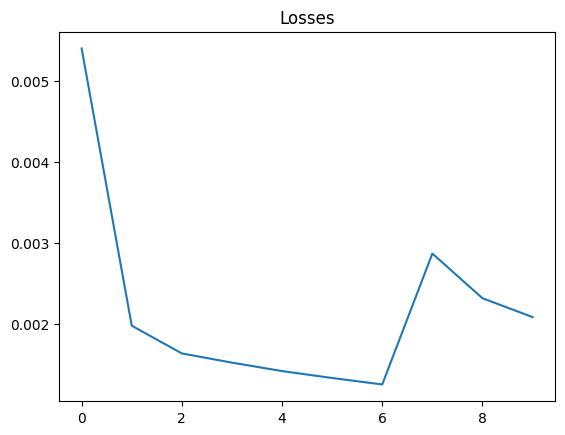

In [39]:
plt.plot(losses)
plt.title("Losses")
plt.show()

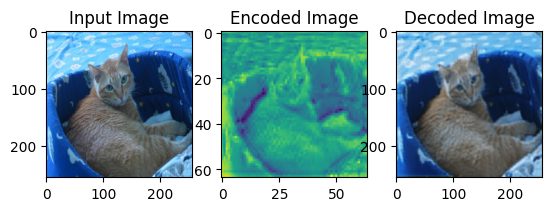

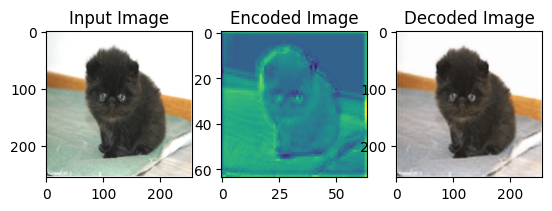

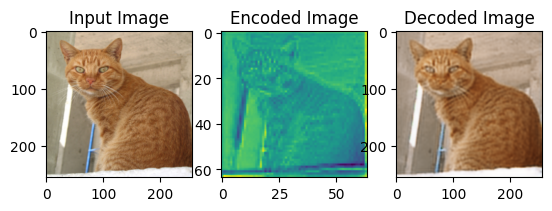

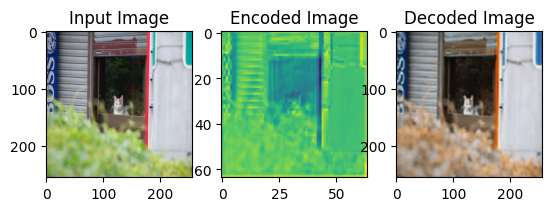

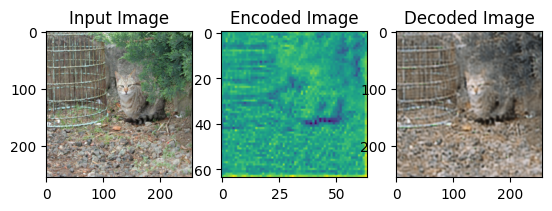

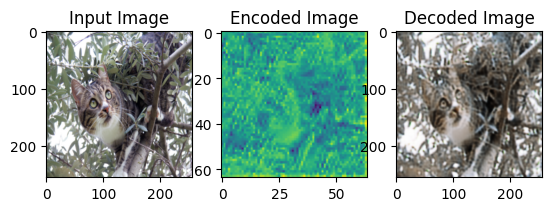

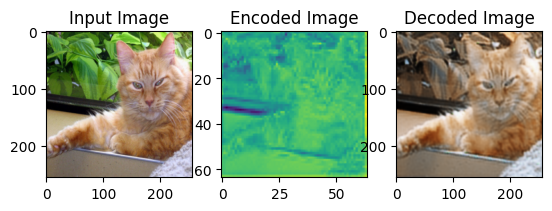

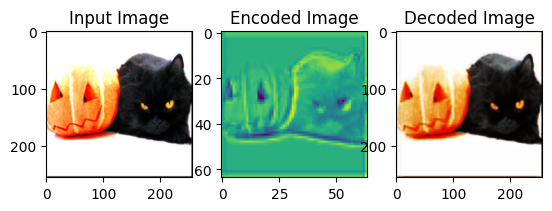

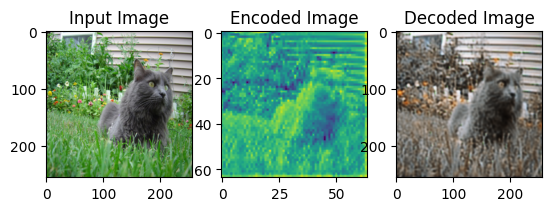

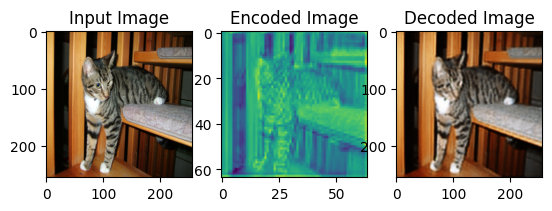

In [40]:
image = next(iter(data_loader))
sample = image[0:10]

for i, img in enumerate(sample, 0):
    x = img.unsqueeze(dim=0).to(device)
    with torch.inference_mode():
        encoded, latent_space = encoder(x) 
        decoded = decoder(encoded)
        
        
    input_image = img.permute(1,2,0)
    encoded_image = latent_space.squeeze(dim=0)[0]
    decoded_image = decoded.squeeze(dim=0).permute(1,2,0)
  
    plt.subplot(1,3,1)
    plt.imshow(input_image)
    plt.title('Input Image')

    plt.subplot(1,3,2)
    plt.imshow(encoded_image.cpu())
    plt.title('Encoded Image')

    plt.subplot(1,3,3)
    plt.imshow(decoded_image.cpu())
    plt.title('Decoded Image')
    plt.show()